In [4]:
import pymysql
import pickle
import json

import math
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

import time
import hdbscan


In [23]:
#target_file = 'data_processing_feb2020/pmids_1995_100k.json'  # name to assign exported results

K_sample = 10000   # rule of thumb - at least 5K samples per cluster for abstracts analysis
                   #                 - at least 25K samples per cluster for titles analysis

N_samplesets = 1
year = 2000  # todo 1960, 1975
path2dir = '/home/brendan/FastData/pubmed2019/pubmed_data_processing/year_pmids/'  # knowledge-garden


In [24]:
config_path = '/home/brendan/Projects/AttentionWildfires/attention_wildfires/mysql_config.json'
db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
                        # todo should move this db_name into config file
with open(config_path, 'r') as f:
    config_data = json.load(f)
    
client_config = {'database': db_name,
                'user': config_data['user'],
                 'password': config_data['lock']}

## init db connection
db = pymysql.connect(**client_config)


### load pretrained umap

In [38]:
print('pop open pickle jar: umap model...')
umap_path = "/home/brendan/FastData/pubmed2019/pubmed_data_processing/dimensionality_reduction_models/umap2D/umap_model0.pkl"
with open(umap_path, 'rb') as file:
    umap_model = pickle.load(file)

pop open pickle jar: umap model...


In [25]:
filename = 'pubmed_state_{}'.format(year)
path2pmids = path2dir + filename
with open(path2pmids,'r') as f:
    data = json.load(f)

year_pub_pmids = data['publications']
N_pubs = len(year_pub_pmids)
print("N pubs: {}".format(N_pubs))
del data # clean up

samples = {}
for i in range(N_samplesets):
    samples[i] = {}
    samples[i]['pmids'] = np.random.choice(year_pub_pmids, K_sample)

N pubs: 530246


In [61]:
def get_embedding_vectors(sample_pmids):
    start_time = time.time()
        
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])
    sql = '''SELECT E.pmid, E.embedding, R.citing
            FROM scibert_mean_embedding as E
            LEFT JOIN citations as R
            ON E.pmid = R.referenced
            WHERE
                (E.pmid IN ({}))
            '''.format(str_fmt, str_fmt)
    cursor = db.cursor()
    cursor.execute(sql)
    # todo includes citations by other papers
    
    pub_embeddings = []
    pub_pmids = []
    cited_by = []
    for i,row in enumerate(cursor):
        pub_pmids.append(row[0])
        pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
        cited_by.append([row[2]])
    cursor.close()
    
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL query composed and executed in {} s".format(elapsed))
    
    return pub_pmids, pub_embeddings, cited_by

    #
    # AND
    #            (R.citing IN ({}))
    #

In [62]:
for i in range(N_samplesets):
    pmids, embeddings, cited_by = get_embedding_vectors(samples[i]['pmids'])
    embeddings_ = umap_model.transform(embeddings)



SQL query composed and executed in 132.13869738578796 s


In [58]:
edges = []
d_xy = {}
for pmid, embedding, citer in zip(pmids,embeddings_,cited_by):
    print(pmid, embedding, citer)
    
    edges.append( (pmid, *citer) )  # *flatten the singleton list
    d_xy[pmid] = embedding
    
# WARNING - TEST THIS, WHY NO DUPLICATES

10592218 [ 3.1017518 -1.9651022] [10767522]
10603381 [2.631786  1.5833906] [10861255]
10610804 [3.8632882 1.9264072] [11115754]
10636921 [2.0960062 3.4449265] [10880515]
10648545 [4.0507274 2.2738383] [10944119]
10648608 [0.15245095 3.9027095 ] [10880523]
10652093 [3.6430712 2.9623287] [11004200]
10653797 [4.9462323  0.32234094] [11118515]
10666445 [3.4786026 2.3297176] [11115754]
10671460 [3.690025  2.4681408] [11080146]
10688666 [1.927206  4.0518813] [11007944]
10688824 [-0.1275244  1.4157947] [10777534]
10692360 [3.6537652 3.0177217] [10884408]
10706118 [1.2523719 2.9856038] [11819679]
10722929 [-0.96074796  2.1486142 ] [10841506]
10728375 [-0.10946864  2.471954  ] [10995395]
10741781 [ 1.1954257 -2.660302 ] [11110257]
10742171 [4.0526915 2.7232478] [11104699]
10746651 [0.27580783 1.3147844 ] [11024560]
10751425 [2.1910815 2.0267313] [10931942]
10754068 [ 2.715989  -0.0423306] [11088017]
10790101 [ 0.9804518 -0.7323796] [11146252]
10793133 [3.1253042 3.7535515] [11090622]
10811719 [

In [ ]:
### create networkx graph and plot using embedding coordinates


NetworkXError: Node 10767522 has no position.

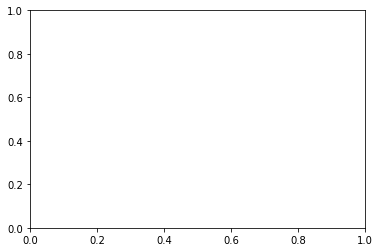

In [55]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(edges)


plt.figure()
nx.draw_networkx(G,
           edge_cmap=plt.cm.Blues,
           pos=d_xy)

'''
plt.figure(figsize=(4,4))
    nx.draw_networkx(G_ego,
           pos=d_layout, #
           with_labels=True,
           labels=labels,
           fontsize=2,
           node_color=[[0.1,0.3,0.2,0.1]],
           node_size=10000, #
           width=0.25,
           edge_cmap=plt.cm.Blues) 
'''